In [14]:
import numpy as np
import pandas as pd
import config as cfg
import seaborn as sns
from scipy.stats import zscore, sem, t

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',  # Set larger title size
    'font.size': 14.0,
    'legend.fontsize': 'medium',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'
})

filename = f"{cfg.RESULTS_DIR}/synthetic_results_censoring.csv"
df = pd.read_csv(filename)

# Define sigma-level (1-sigma/2-sigma)
sigma_level = 2

# Define a threshold for z-scores (commonly 3)
z_threshold = 3

# Apply z-score filtering to numeric columns
columns = ['ci_harrell_error', 'ci_uno_error', 'ci_dep_ipcw_error',
           'ibs_ipcw_error', 'ibs_dep_bg_error', 'mae_margin_error',
           'mae_dep_bg_error']
df = df[(zscore(df[columns]) < z_threshold).all(axis=1)]

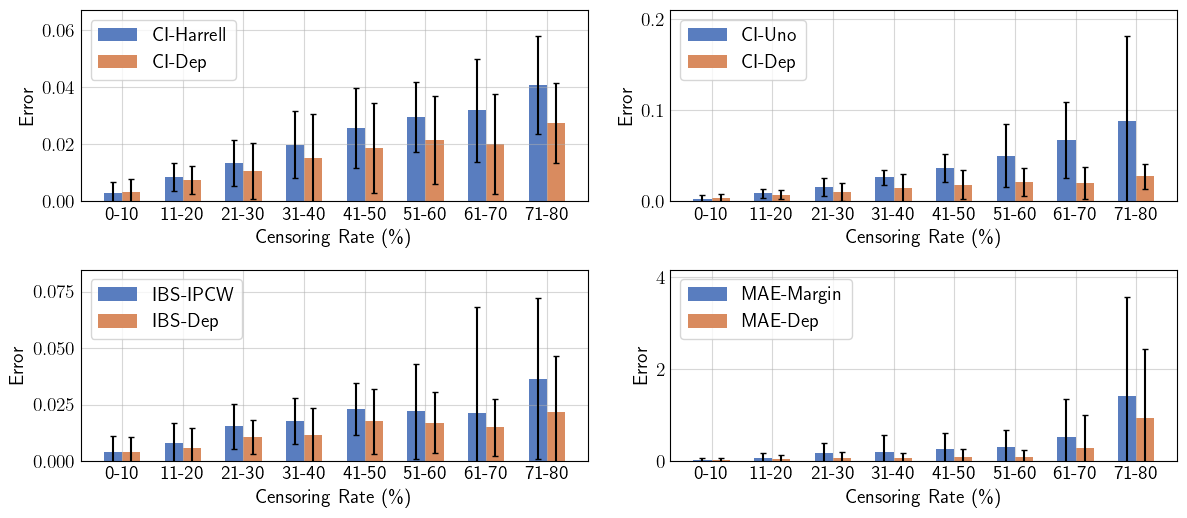

In [15]:
# Define error columns with legend names
error_columns = [
    ('ci_harrell_error', "ci_dep_ipcw_error", "CI-Harrell", "CI-Dep"),
    ("ci_uno_error", "ci_dep_ipcw_error", "CI-Uno", "CI-Dep "),
    ('ibs_ipcw_error', "ibs_dep_bg_error", "IBS-IPCW", "IBS-Dep"),
    ('mae_margin_error', "mae_dep_bg_error", "MAE-Margin", "MAE-Dep")
]

# Convert censoring_rate to percentage for binning
df["censoring_pct"] = df["censoring_rate"] * 100

# Define bins and labels
bins = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
labels = ["0-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80"]
df['censoring_bin'] = pd.cut(df['censoring_rate'], bins=bins, labels=labels, include_lowest=True)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

# Plot each metric pair
for i, (metric1, metric2, label1, label2) in enumerate(error_columns):
    grouped = df.groupby("censoring_bin")[[metric1, metric2]].agg(['mean', 'std'])
    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()

    # Drop bins where both metrics are NaN
    grouped = grouped.dropna(subset=[f"{metric1}_mean", f"{metric2}_mean", f"{metric1}_std", f"{metric2}_std"])

    plot_df = pd.DataFrame({
        "censoring_bin": pd.concat([grouped["censoring_bin"], grouped["censoring_bin"]]),
        "Metric": [metric1]*len(grouped) + [metric2]*len(grouped),
        "Mean": pd.concat([grouped[f"{metric1}_mean"], grouped[f"{metric2}_mean"]]),
        "Std": pd.concat([grouped[f"{metric1}_std"], grouped[f"{metric2}_std"]])
    })

    plot_df = plot_df.dropna(subset=["Mean", "Std"])

    # Plot bars
    ax = axes[i]
    sns.barplot(
        data=plot_df,
        x="censoring_bin", y="Mean", hue="Metric",
        ax=ax,
        capsize=0.1,
        errorbar=None,
        palette="muted",
        alpha=1,
        linewidth=3,
        width=0.6
    )

    # Add error bars manually
    hue_order = [metric1, metric2]
    for metric_idx, metric in enumerate(hue_order):
        bars = [bar for j, bar in enumerate(ax.containers[metric_idx])]
        std_vals = plot_df[plot_df['Metric'] == metric]["Std"].values
        for bar, err in zip(bars, std_vals):
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_height()
            ax.errorbar(x, y, yerr=sigma_level*err, fmt='none', c='black', capsize=2)

    # Replace legend
    ax.legend_.remove()
    ax.legend(
        handles=ax.containers[:2],
        labels=[label1, label2],
        fontsize=14
    )

    # Set axes labels
    ax.set_ylabel("Error")
    ax.set_xlabel("Censoring Rate (\%)")
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(0, y_max * 1.1)
    
    ax.grid(True, alpha=0.5)
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Save figure
plt.savefig(f"{cfg.PLOTS_DIR}/synthetic_censoring.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()